In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from itertools import combinations_with_replacement, permutations
from typing import Tuple

In [2]:
x_lim = (0,10)
y_lim = (0,10)
alpha_lim = (-np.pi,np.pi)

In [3]:
samples = np.meshgrid(np.linspace(*x_lim, 50), np.linspace(*y_lim, 50), np.linspace(*alpha_lim, 50))
samples = np.array(samples).transpose([1,2,3,0])

In [4]:
def add_tuples(lhs: Tuple, rhs: Tuple) -> Tuple:
    return tuple(np.array(lhs)+np.array(rhs))

In [5]:
def calc_node_distance(lhs, rhs):
    lhs = np.array(lhs)
    rhs = np.array(rhs)
    loss_ang = lambda a1, a2: np.sqrt((np.cos(a1) - np.cos(a2))**2 + (np.sin(a1) - np.sin(a2))**2)  # angle difference
    def loss_dir(a1, a2):  # direction difference
        d1 = np.array([np.cos(a1), np.sin(a1)])  # directions are always normalized
        d2 = np.array([np.cos(a2), np.sin(a2)])
        return max(1 - d1@d2 - 0.001, 0)  # allows margin of error = np.rad2deg(np.arccos(1-0.001)) about 2.5deg
    return np.linalg.norm(rhs[:2]-lhs[:2]) + 1/2*loss_ang(lhs[2], rhs[2]) + 1*(loss_dir(lhs[2], np.arctan2(rhs[1]-lhs[1], rhs[0]-lhs[0])) if np.linalg.norm(lhs[:2]-rhs[:2])>1e-5 else 0)

In [6]:
# Build graph
G = nx.DiGraph()
#nodes = [[[None]*samples.shape[2]]*samples.shape[1]]*samples.shape[0]
for i, j, k in product(*map(range,samples.shape[:-1])):
    G.add_node((i,j,k))

directions = set.union(*map(set,map(permutations,combinations_with_replacement([-1,0,1], 3)))) - {(0,0,0)}  # (0,0,1), ..., (1,0,1), (1,1,1)
#directions |= {(1,0,-1), (0,1,-1), (1,1,-1)}
for i, j, k in product(*map(range,samples.shape[:-1])):
    for d in directions:
        t = (i,j,k)
        t_ = add_tuples(t, d)
        
        try:
            distance = calc_node_distance(samples[t], samples[t_])
            G.add_edge(t, t_, weight=distance)
            #distance_ = calc_node_distance(samples[t_], samples[t])
            #G.add_edge(t_, t, weight=distance_)
        except IndexError:
            pass

In [7]:
# Remove nodes
print(len(G), " nodes before removing some")
def remove_around(center, rad):
    for i, j in product(*map(range,samples.shape[:2])):
        if np.linalg.norm(np.array((i,j)) - np.array(center)) < rad:
            for k in range(samples.shape[2]):
                G.remove_node((i,j,k))
remove_around((samples.shape[0]//6,samples.shape[1]//3), samples.shape[0]//5)
remove_around((samples.shape[0]//4*3,samples.shape[1]//3*2), samples.shape[0]//5)

print(len(G), " nodes after removing some")

132651  nodes before removing some
102601  nodes after removing some


In [8]:
path = nx.shortest_path(G, (0,0,samples.shape[2]//4*3), (samples.shape[0]-1,samples.shape[1]-1,samples.shape[2]//(1/0.9)), weight='weight')

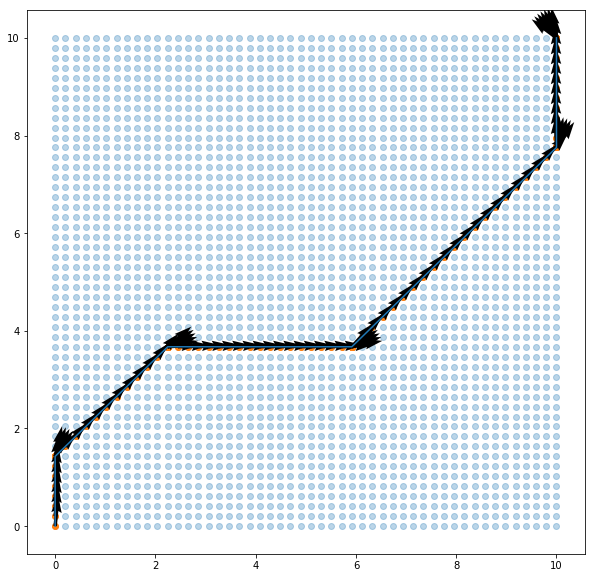

In [9]:
scatter_points = samples[:,:,0,:2]
plt.figure(figsize=(10,10))
plt.scatter(scatter_points[:,:,0].flatten(), scatter_points[:,:,1].flatten(), alpha=0.3)

path_points = np.array([samples[p] for p in path])
plt.scatter(path_points[:,0], path_points[:,1])
plt.plot(path_points[:,0], path_points[:,1])
plt.quiver(path_points[:,0], path_points[:,1], np.cos(path_points[:,2]), np.sin(path_points[:,2]))

# Below is just some plotting

In [10]:
nodes_to_draw = {(i,j,0) for i, j in product(*map(range, samples.shape[:2]))} & set(G.nodes())
node_pos = dict(zip(nodes_to_draw, [(samples[n][0], samples[n][1]) for n in nodes_to_draw]))
edges_to_draw = set(filter(lambda e: e[0] in nodes_to_draw and e[1] in nodes_to_draw, G.edges()))

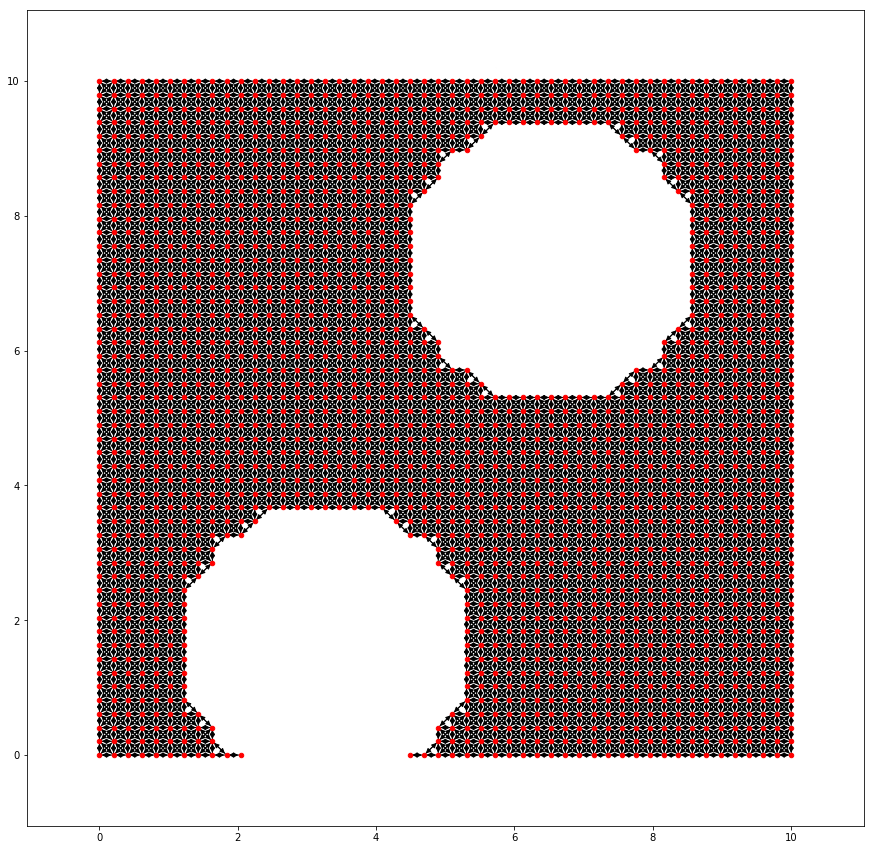

In [11]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G, pos=node_pos, nodelist=nodes_to_draw, node_size=20, edgelist=edges_to_draw, with_labels=False)